In [104]:
from data_utils import *

In [105]:
from plotnine import *

In [106]:
def custom_theme():
    return theme(
        plot_title=element_text(size=11),
        strip_text=element_text(size=10),
        legend_title=element_text(size=9),           
        legend_text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text_x=element_text(size=8, rotation=90, ha='center', ma='right'),
        axis_text_y=element_text(size=8)
    )

In [107]:
MODEL_COLORS = {
    'KIT-MeanEnsemble': '#009E73',
    'KIT-LightGBM': '#B30000',
    'KIT-TSMixer': '#E69F00',
    'KIT-hhh4': '#3C4AAD',
    'KIT-simple_nowcast': '#56B4E9',
    'RIVM-GAM' :  '#80471C',
    'MPIDS-PS_embedding' : '#CC79A7',
    'Historical': '#000000',
    'Persistence' : '#80471C',
}

In [108]:
MODEL_ORDER = ['KIT-simple_nowcast', 'KIT-epinowcast', 'RIVM-GAM','KIT-MeanEnsemble', 'KIT-LightGBM', 'KIT-TSMixer', 'KIT-hhh4', 'MPIDS-PS_embedding']

In [136]:
def load_scores(diseases=['sari', 'are'], by_horizon=False):
    df = pd.read_csv('../data/scores.csv')
    df['level'] = pd.Categorical(df['level'], categories=['national', 'age', 'states'], ordered=True)
    
    if isinstance(diseases, str):
        diseases = [diseases]
    df = df[df['disease'].isin(diseases)]
    
    group_cols = ['disease', 'level', 'model'] + (['horizon'] if by_horizon else [])
    return df.groupby(group_cols, observed=True)[['spread', 'overprediction', 'underprediction', 'wis', 'c50', 'c95']].mean().reset_index()

In [134]:
df = pd.read_csv('../data/scores.csv')

In [137]:
df_are = load_scores(diseases=['are'], by_horizon=False)

df_are_long = pd.melt(df_are, id_vars=['disease', 'level', 'model'], value_vars=['wis', 'underprediction', 'spread', 'overprediction'], 
                 var_name='metric', value_name='value')

In [138]:
df_sari = load_scores(diseases=['sari'], by_horizon=False)

df_sari_long = pd.melt(df_sari, id_vars=['disease', 'level', 'model'], value_vars=['wis', 'underprediction', 'spread', 'overprediction'], 
                 var_name='metric', value_name='value')

In [139]:
def plot_total_scores(df_long, models=None):
    
    if models is not None:
        df_long = df_long[df_long.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in df_long.model.unique()]
    df_long['model'] = pd.Categorical(df_long['model'], categories=model_order, ordered=True) 

    p = (ggplot()
        + facet_wrap('~level', scales='free_y', labeller=lambda x: ('National level' if x == 'national' else 'State level' if x == 'states' else 'Age groups'))
        + geom_bar(df_long[df_long.metric == 'wis'], aes(x='model', y='value', color='model'), fill='white', stat='identity', width=0.7, show_legend=False)
        + geom_bar(df_long[df_long.metric != 'wis'], aes(x='model', y='value', fill='model', alpha='metric', color='model'), size=0.1, stat='identity', width=0.7, 
                   show_legend={'color': False,
                                'fill': False,
                                'alpha': True})
        + scale_color_manual(values=MODEL_COLORS)
        + scale_fill_manual(values=MODEL_COLORS)
        + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=False))
        + labs(x="", y="WIS", color="Model", alpha="Decomposition of WIS:", title="")
        #+ coord_flip()
        + theme_bw()
        + custom_theme()
        + theme(legend_position='right',
                legend_title_position='top')
        )
    return p

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


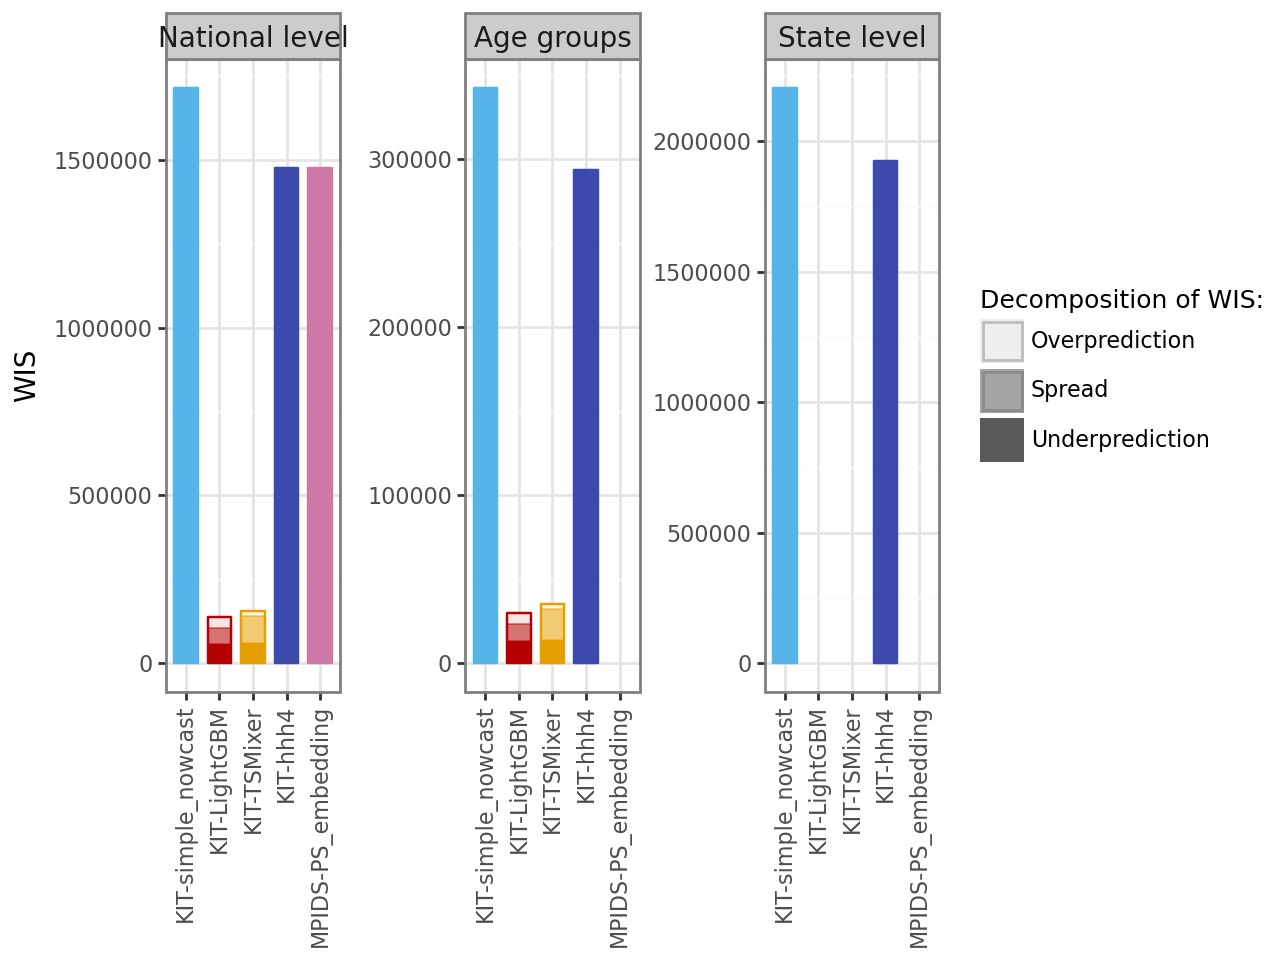

In [140]:
p = plot_total_scores(df_are_long, models=df.model.unique())
p

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


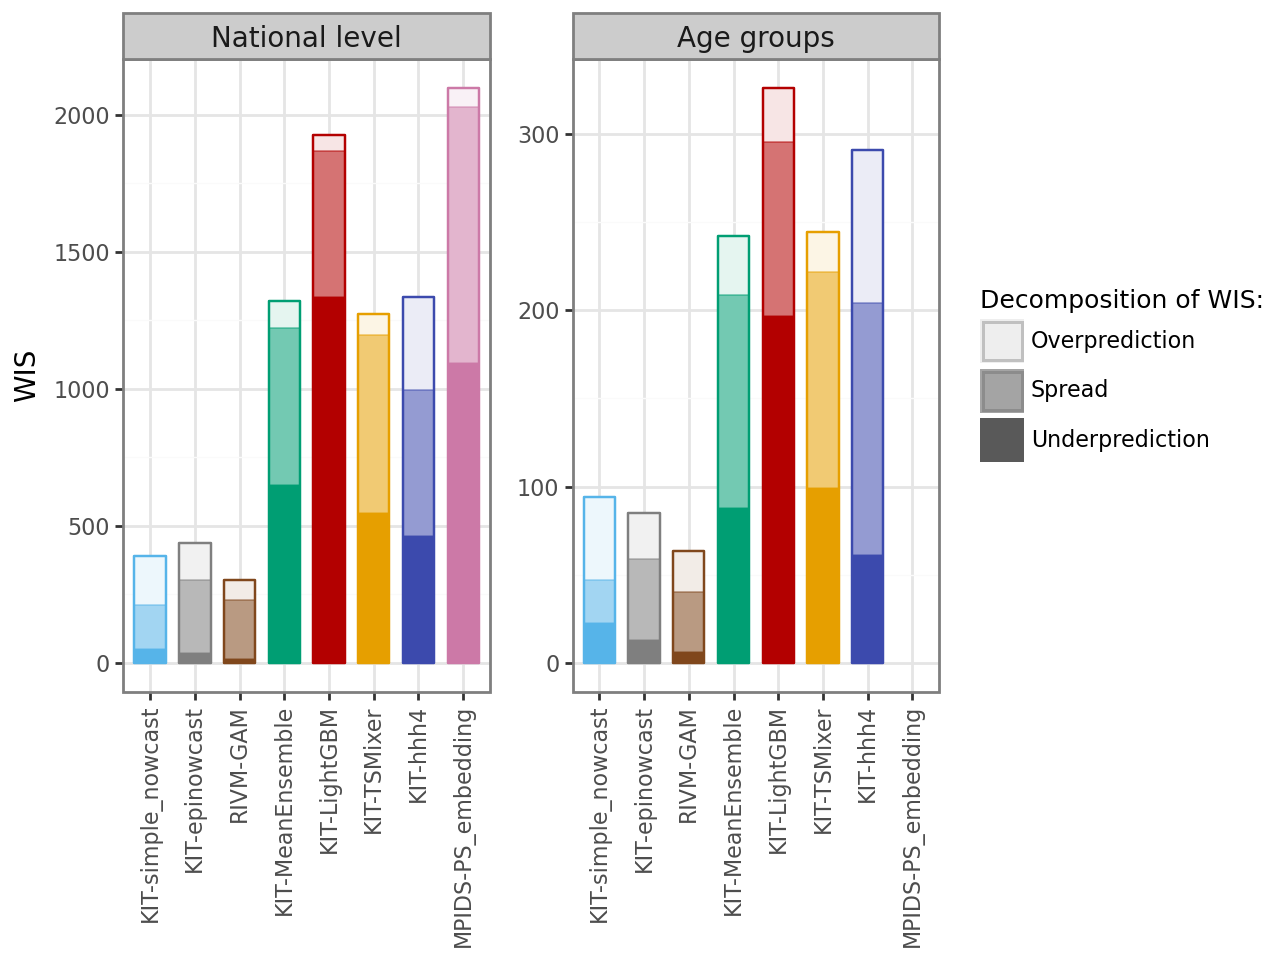

In [141]:
p = plot_total_scores(df_sari_long, models=df.model.unique())
p

In [142]:
def plot_coverage(df_wide, models=None):
    if models is not None:
        df_wide = df_wide[df_wide.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in df_wide.model.unique()]
    df_wide['model'] = pd.Categorical(df_wide['model'], categories=model_order, ordered=True) 
    
    alphas = {"50%": 0.7, "95%": 0.4}

    p = (
        ggplot(df_wide, aes(x='model'))
        + facet_wrap('~level', nrow=1, scales='fixed', labeller=lambda x: ('National level' if x == 'national' else 'Age groups'))
        + expand_limits(y=1)  # Ensure y-axis starts at 1

        # Add columns for 95% and 50% coverage with respective alpha transparency
        + geom_col(aes(y='c95'), width=0.7, fill='white', show_legend={'fill': False})
        + geom_col(aes(y='c95', fill='model', alpha='"95%"'), width=0.7, show_legend={'fill': False})
        + geom_col(aes(y='c50', fill='model', alpha='"50%"'), width=0.7, show_legend={'fill': False})

        # Horizontal dashed lines at y = 0.5 and y = 0.95
        + geom_hline(yintercept=[0.5, 0.95], linetype='dashed')

        # Customize y-axis labels to display "0" instead of omitting 0
        + scale_y_continuous(labels=lambda y: ["0" if val == 0 else val for val in y])

        # Labels for axes, color, and alpha legend
        + labs(
            x='',
            y="Empirical coverage",
            color="Model",
            alpha="Prediction interval: "
        )

        # Conditional color mapping for fill
        + scale_fill_manual(values=MODEL_COLORS)

        # Flip coordinates to make x-axis vertical
        #+ coord_flip()

        # Custom alpha levels for each bar transparency
        + scale_alpha_manual(values=alphas, guide=guide_legend(reverse=False))

        # Basic theme with customized legend position and alignment
        + theme_bw()
        + custom_theme()
        + theme(
            legend_position='right',
            legend_title_position='top',
            panel_spacing=0.025
        )
    )

    return p

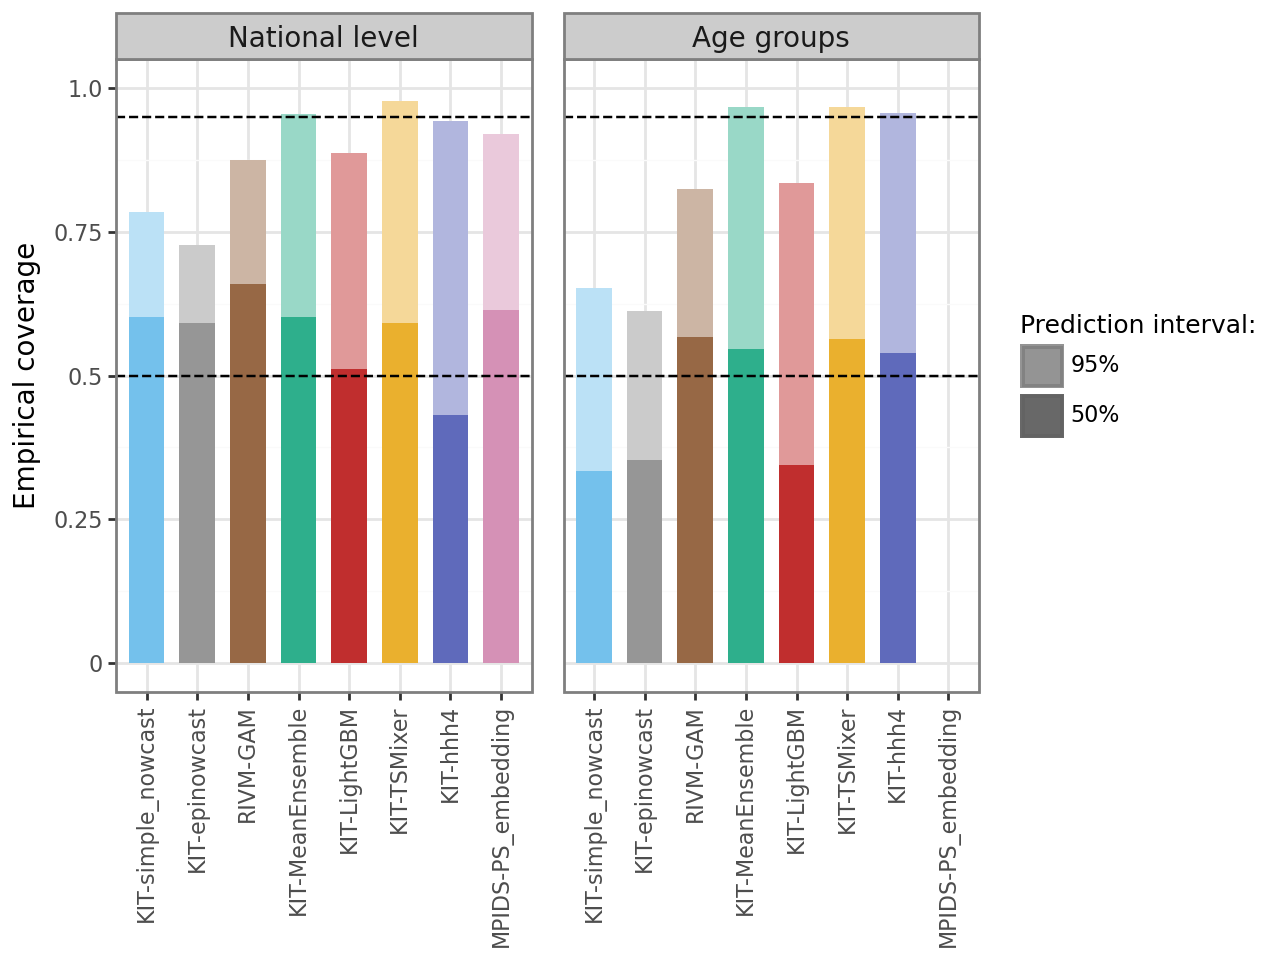

In [144]:
p = plot_coverage(df_sari)
p

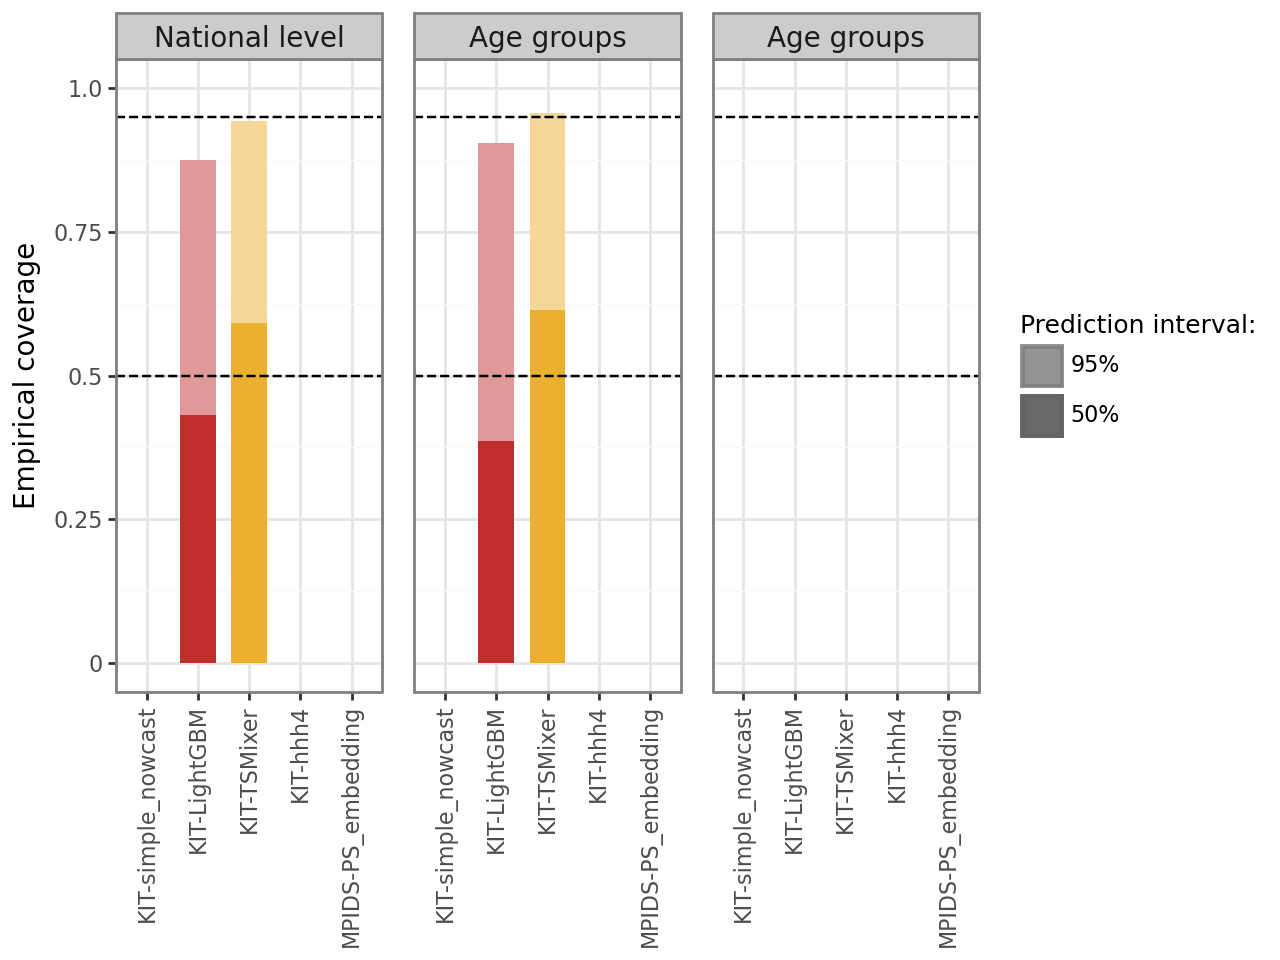

In [145]:
p = plot_coverage(df_are)
p